# 3章 顧客の全体像を把握する

ここでは、スポーツジムの会員データを使って顧客の行動を分析していきます。  
これまでと同様にまずはデータを理解し、加工した後、  
顧客の行動データを分析していきましょう。  
ここでは、機械学習に向けての初期分析を行います。

### ノック21：データを読み込んで把握しよう

In [175]:
import pandas as pd

campaign_master = pd.read_csv('campaign_master.csv')
print(len(campaign_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,通常
1,CA2,入会費半額
2,CA3,入会費無料


In [176]:
class_master = pd.read_csv('class_master.csv')
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,オールタイム,10500
1,C02,デイタイム,7500
2,C03,ナイト,6000


In [177]:
customer_master = pd.read_csv('customer_master.csv')
print(len(customer_master))
customer_master.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


In [178]:
use_log = pd.read_csv('use_log.csv')
print(len(use_log))
use_log.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


### ノック22：顧客データを整形しよう

In [179]:
#顧客データに会員区分とキャンペーン区分をジョインする
customer_join = pd.merge(customer_master, class_master, on='class', how='left')
customer_join = pd.merge(customer_join, campaign_master, on='campaign_id', how='left')
customer_join.head()


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,ナイト,6000,通常


In [180]:
# 会員マスタのデータを検査
print(len(customer_master))
print(len(customer_join))

4192
4192


In [181]:
#欠損値の確認
customer_join.isnull().sum()

#end_dateは退会日時で、退会していない会員は欠損地になっていることが推測される

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

### ノック23：顧客データの基礎集計をしよう

In [182]:
#分析軸で区切る
#会員区分、キャンペーン区分、性別、すでに退会しているかをまずは見ていく

customer_join.groupby('class_name').count()['customer_id']

class_name
オールタイム    2045
デイタイム     1019
ナイト       1128
Name: customer_id, dtype: int64

In [183]:
customer_join.groupby('campaign_name').count()['customer_id']

campaign_name
入会費半額     650
入会費無料     492
通常       3050
Name: customer_id, dtype: int64

In [184]:
customer_join.groupby('gender').count()['customer_id']

gender
F    1983
M    2209
Name: customer_id, dtype: int64

In [185]:
print(len(customer_join['customer_id']))
customer_join.groupby('is_deleted').count()['customer_id']

4192


is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

In [186]:
# 基礎集計の段階で仮説や疑問が湧く。関係部署にヒアリングもあり。
# 2018-04-01以降の入会会員数を集計してみる。
customer_join['start_date'] = pd.to_datetime(customer_join['start_date'])

customer_start = customer_join.loc[customer_join['start_date'] > pd.to_datetime('20180401')]
print(len(customer_start))

# 退会会員より11人多くなる。


1361


### ノック24：最新顧客データの基礎集計をしよう

In [187]:
# 最新月のデータを取得して、会員の現状を把握する。
# 最新月(2019年03月)に退会している会員または、在籍している会員に絞り込む

customer_join['end_date'] = pd.to_datetime(customer_join['end_date'])
customer_newer = customer_join.loc[(customer_join['end_date'] >= pd.to_datetime('20190331')) | (customer_join['end_date'].isna())]
print(len(customer_newer))

customer_newer['end_date'].unique()

customer_newer.head()


2953


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常


In [188]:
customer_newer.groupby('class_name').count()['customer_id']

class_name
オールタイム    1444
デイタイム      696
ナイト        813
Name: customer_id, dtype: int64

In [189]:
customer_newer.groupby('campaign_name').count()['customer_id']

campaign_name
入会費半額     311
入会費無料     242
通常       2400
Name: customer_id, dtype: int64

In [190]:
customer_newer.groupby('gender').count()['customer_id']

gender
F    1400
M    1553
Name: customer_id, dtype: int64

### ノック25：利用履歴データを集計しよう

In [191]:
use_log.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [192]:
# ユーザー毎に月毎の利用回数を取得する

# 利用時間を整形する。月別のデータを取得する
use_log['usedate'] = pd.to_datetime(use_log['usedate'])
use_log['年月'] = use_log['usedate'].dt.strftime('%Y%m')
use_log.head()

,log_id,customer_id,usedate,年月
0,L00000049012330,AS009373,2018-04-01,201804
1,L00000049012331,AS015315,2018-04-01,201804
2,L00000049012332,AS040841,2018-04-01,201804
3,L00000049012333,AS046594,2018-04-01,201804
4,L00000049012334,AS073285,2018-04-01,201804


In [193]:
# 月別で顧客の利用回数を取得する
use_log_month = use_log.groupby(['年月', 'customer_id'], as_index=False).count()
use_log_month.head()

,年月,customer_id,log_id,usedate
0,201804,AS002855,4,4
1,201804,AS009013,2,2
2,201804,AS009373,3,3
3,201804,AS015315,6,6
4,201804,AS015739,7,7


In [194]:
# log_idの名称変更、不要なカラムを削除
# .rename()でカラムの指定は{}
# .inplace=Trueによって変数の格納を省略
use_log_month.rename(columns={'log_id':'count'}, inplace=True)
del use_log_month['usedate']
use_log_month.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [195]:
# 顧客毎に絞り込み、平均値、中央値、最大値、最小値を算出する

# .agg(['mean','median', 'max', 'min'])['count']はdf全体に'mean'などの処理をするため、
# 以下のように集計するカラムを指定する　use_log_month.groupby('customer_id')['count']
use_log_customer = use_log_month.groupby('customer_id')['count'].agg(['mean','median', 'max', 'min'])
use_log_customer = use_log_customer.reset_index(drop=False)
use_log_customer

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4
...,...,...,...,...,...
4187,TS995853,9.500000,9.5,11,8
4188,TS998593,8.142857,8.0,9,7
4189,TS999079,4.916667,5.5,9,2
4190,TS999231,4.666667,5.0,8,1


In [196]:
print(use_log_month['customer_id'].dtypes)

object


### ノック26：利用履歴データから定期利用フラグを作成しよう

In [197]:
use_log.head()

,log_id,customer_id,usedate,年月
0,L00000049012330,AS009373,2018-04-01,201804
1,L00000049012331,AS015315,2018-04-01,201804
2,L00000049012332,AS040841,2018-04-01,201804
3,L00000049012333,AS046594,2018-04-01,201804
4,L00000049012334,AS073285,2018-04-01,201804


In [198]:
# 利用頻度を顧客毎に、月/曜日別に集計し最大値が4以上の曜日が一カ月でもあったユーザーをフラグ1とする

# .dt.weekdayで曜日に0-6の数字をふる。月曜が0、日曜が6
use_log['weekday'] = use_log['usedate'].dt.weekday
# as_index=False で３つのカラムをインデックスとさせない。.count()でデータの個数をカウントし、カラムを指定。
use_log_weekday = use_log.groupby(['customer_id', '年月', 'weekday'], as_index=False).count()[['customer_id', '年月', 'weekday', 'log_id']]

# カラム名の変更,inplace=Trueで変数への格納不要
use_log_weekday.rename(columns={'log_id' : 'count'}, inplace=True)

use_log_weekday

,customer_id,年月,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1
...,...,...,...,...
93328,TS999855,201901,1,1
93329,TS999855,201901,5,4
93330,TS999855,201901,6,1
93331,TS999855,201902,5,4


In [199]:
# 顧客毎に、月別の利用回数の最大値を取得。最大値が4以上のときにフラグを立てる。

use_log_weekday = use_log_weekday.groupby('customer_id', as_index=False).max()[['customer_id', 'count']]

# フラグを格納するカラムを追加
use_log_weekday['routine_flg'] = 0

# .whereメソッドで、カウントが４未満の場合、routing_flgを１に置換。
use_log_weekday['routine_flg'] = use_log_weekday['routine_flg'].where(use_log_weekday['count'] < 4, 1)

use_log_weekday.head()


,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


### ノック27：顧客データと利用履歴データを結合しよう

In [200]:
# use_log_customerとuse_log_weekdayをcustomer_joinにジョインする
print(customer_join.head(0))
print(use_log_customer.head(0))
print(use_log_weekday.head(0))

Empty DataFrame
Columns: [customer_id, name, class, gender, start_date, end_date, campaign_id, is_deleted, class_name, price, campaign_name]
Index: []
Empty DataFrame
Columns: [customer_id, mean, median, max, min]
Index: []
Empty DataFrame
Columns: [customer_id, count, routine_flg]
Index: []


In [201]:
customer_join = pd.merge(customer_join, use_log_customer, on='customer_id', how='left')
customer_join = pd.merge(customer_join, use_log_weekday, on='customer_id', how='left')

customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,count,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,4,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,5,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,5,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,5,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,5,1


In [202]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
count               0
routine_flg         0
dtype: int64

### ノック28：会員期間を計算しよう

In [203]:
# 退会していないユーザーは期間集計ができないため、仮に2019年4月30日として会員期間を算出する
# relativedeltaは日付や時間の操作を簡単に行うためのクラス

from dateutil.relativedelta import relativedelta

customer_join['culc_date'] = customer_join['end_date']
# 欠損値に全て20190430の日付を入れる。
customer_join['culc_date'] = customer_join['culc_date'].fillna(pd.to_datetime('20190430'))

# カラムの初期化
customer_join['menber_period'] = 0

# dfの行数ぶんだけループ
for i in range(len(customer_join)):
    # relativedeltaの引数にある日数の差を返す。引数に順番はない。
    # iloc[i]は指定した列のi番目を取得する。[i]みたいなもの。
    # deltaにはそれぞれ、年、月、日のデータをもつ。 例：relativedelta(years=+3, months=+11, days=+29)
    delta = relativedelta(customer_join['culc_date'].iloc[i], customer_join['start_date'].iloc[i])

    # 粒度を月に合わせて格納する。

    # 以下のコードはチェーン代入で警告が出る。
    #customer_join['menber_period'].iloc[i] = delta.years *12 + delta.months
    #i番目のmenber_periodを抽出する。抽出した値に、deltaのデータを代入する
    customer_join.loc[i, 'menber_period'] = delta.years *12 + delta.months

customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,count,routine_flg,culc_date,menber_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,4,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,5,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,5,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,5,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,5,1,2019-04-30,47


### ノック29：顧客行動の各種統計量を把握しよう

In [204]:
customer_join[['mean', 'median', 'max', 'min']].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [205]:
# 継続利用ユーザーの集計

customer_join.groupby('routine_flg').count()['customer_id']

routine_flg
0     779
1    3413
Name: customer_id, dtype: int64

Text(0, 0.5, 'Membership')

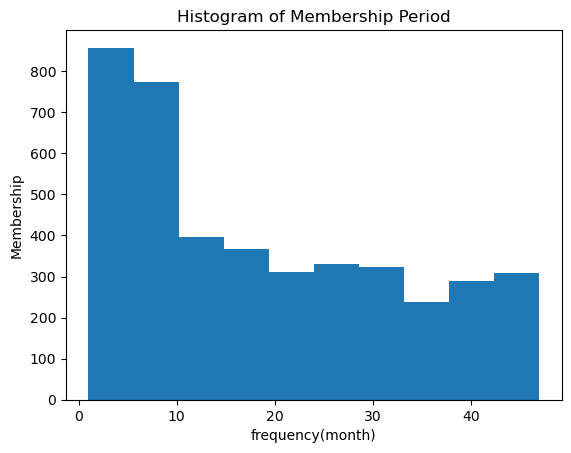

In [211]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(customer_join['menber_period'])
# タイトルとラベルの追加
plt.title('Histogram of Membership Period')
plt.xlabel('frequency(month)')
plt.ylabel('Membership')

10カ月以内のユーザーが大きな割合を締めている。継続会員の創出は難しいことが示唆されている。

### ノック30：退会ユーザーと継続ユーザーの違いを把握しよう

In [215]:
# 退会ユーザーと継続ユーザーの違いをdescribeで比較する

customer_stay = customer_join.loc[customer_join['is_deleted'] == 0]
customer_stay.describe()


,start_date,end_date,is_deleted,price,mean,median,max,min,count,routine_flg,culc_date,menber_period
count,2842,0,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842,2842.000000
mean,2017-04-03 22:42:28.627726848,NaT,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,4.865588,0.984166,2019-04-30 00:00:00,23.970443
min,2015-05-01 00:00:00,NaT,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,2.000000,0.000000,2019-04-30 00:00:00,1.000000
25%,2016-05-01 00:00:00,NaT,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,5.000000,1.000000,2019-04-30 00:00:00,12.000000
50%,2017-04-01 00:00:00,NaT,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,5.000000,1.000000,2019-04-30 00:00:00,24.000000
75%,2018-04-05 00:00:00,NaT,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,5.000000,1.000000,2019-04-30 00:00:00,35.000000
max,2019-03-15 00:00:00,NaT,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,5.000000,1.000000,2019-04-30 00:00:00,47.000000
std,NaN,NaN,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.406154,0.124855,NaN,13.746761


In [216]:
customer_end = customer_join.loc[customer_join['is_deleted'] == 1]
customer_end.describe()

,start_date,end_date,is_deleted,price,mean,median,max,min,count,routine_flg,culc_date,menber_period
count,1350,1350,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350,1350.000000
mean,2018-01-20 10:45:20,2018-10-17 16:23:28,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,3.215556,0.456296,2018-10-17 16:23:28,8.026667
min,2016-05-01 00:00:00,2018-04-30 00:00:00,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2018-04-30 00:00:00,1.000000
25%,2017-10-01 00:00:00,2018-06-30 00:00:00,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,2.000000,0.000000,2018-06-30 00:00:00,4.000000
50%,2018-03-01 00:00:00,2018-10-31 00:00:00,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,3.000000,0.000000,2018-10-31 00:00:00,7.000000
75%,2018-06-03 00:00:00,2019-01-31 00:00:00,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,4.000000,1.000000,2019-01-31 00:00:00,11.000000
max,2019-02-11 00:00:00,2019-03-31 00:00:00,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,5.000000,1.000000,2019-03-31 00:00:00,23.000000
std,NaN,NaN,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,1.217087,0.498271,NaN,5.033692


In [217]:
customer_join.to_csv('customer_join.csv', index=False)